# Predict Geographic Context from Landscape Photos

Kaggle URL: https://www.kaggle.com/competitions/predict-geographic-context-from-landscape-photos/overview

Some training images were missing from the original 14Gb archive (as per Kaggle description). Download missing ones, then add missing ones into our training folder:

```
rsync -a extra_images/ train_images/
```

In [32]:
import pandas as pd
import numpy as np
import os
import gc # garbage collection
import pickle

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, Subset, TensorDataset, random_split
from torchvision import transforms
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR

import clip

from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm  # notebook-aware bar

In [33]:
num_labels = 49
device = 'cpu'

# Pre-compute embeddings on all training images once 🏹

In [35]:
# Combine original + missing training data (img IDs + labels) into a single CSV
train = pd.concat([
    pd.read_csv('train.csv'),
    pd.read_csv('train-extra.csv')
]).drop(columns=['tags'])

metadata_cols = ['gridimage_id', 'title', 'grid_reference']
metadata = pd.concat([
    pd.read_csv('metadata.csv', on_bad_lines='skip', usecols=metadata_cols),
    pd.read_csv('metadata-extra.csv', on_bad_lines='skip', encoding='latin1', usecols=metadata_cols)
])

combined = (
    train.merge(
        metadata, on='gridimage_id', how='inner'
    ).assign(
        gridimage_id=lambda df_: df_.gridimage_id.astype(int)
    )
    .set_index('gridimage_id')
)

tags = train.columns[1:num_labels+1]
assert len(tags) == num_labels and all([ tag.startswith('tag') for tag in tags ])
image_ids = combined.index
ys = combined.loc[:, tags]
titles = combined.title.fillna('')

In [38]:
titles

gridimage_id
6602                             Heathrow Airport
7058       The west summit of Beinn na h-Eaglaise
7567                   Summit of Meall an Lundain
8281                    Summit of Beinn na Gucaig
9017                      Duns Castle and Hen Poo
                            ...                  
7562941                Exton : Xmoor-Rox Festival
7562943                Exton : Xmoor-Rox Festival
7562944                Exton : Xmoor-Rox Festival
7563159                           Kineil terminal
7563429                Shell garage - Trumpington
Name: title, Length: 657235, dtype: object

In [39]:
# How many tags per image do we have?
pd.Series(ys.sum(axis=1)).value_counts() / ys.shape[0] * 100

1     42.547643
2     35.661369
3     16.130303
4      4.393406
5      1.044071
6      0.197342
7      0.019628
8      0.004108
9      0.001065
10     0.000456
12     0.000152
20     0.000152
19     0.000152
13     0.000152
Name: count, dtype: float64

In [12]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [13]:
model, preprocess = clip.load("ViT-B/32", device=device)

In [ ]:
%%time

batch_size = 10_000
batch_idx = 4

exist_ids = []
img_embeds = []
txt_embeds = []

for img_id in tqdm(image_ids[batch_size*batch_idx:]):
    
    path = Path('train_images') / f'{img_id//10000:05d}' / f'{img_id}.jpg'
    
    if path.exists():

        # Image encoder
        img = preprocess(Image.open(path)).unsqueeze(0).to(device)
        with torch.no_grad():
            feat_img = model.encode_image(img)
        feat_img = feat_img.squeeze(0).cpu().detach()

        # Text encoder
        txt_tokens = clip.tokenize([titles.loc[img_id]]).to(device)
        with torch.no_grad():
            feat_txt = model.encode_text(txt_tokens)
        feat_txt = feat_txt.squeeze(0).cpu().detach()
        
        exist_ids.append(img_id)
        img_embeds.append(feat_img)
        txt_embeds.append(feat_txt)

        if len(exist_ids) >= batch_size:
            # Write batch to file
            with open(f'interim/clip-train-embeds-{batch_idx}.pkl', 'wb') as f:
                pickle.dump(
                    [(id, img, txt) for id, img, txt in zip(exist_ids, img_embeds, txt_embeds)],
                    f
                )
            exist_ids.clear(); img_embeds.clear(); txt_embeds.clear()
            batch_idx += 1

# Write remaining
with open(f'interim/clip-train-embeds-{batch_idx}.pkl', 'wb') as f:
    pickle.dump(
        [(id, img, txt) for id, img, txt in zip(exist_ids, img_embeds, txt_embeds)],
        f
    )

## Split training data into train/val sets and use for all experiments

In [ ]:
train_tuples = []

for i in range(65):
    with open(f'interim/clip-train-embeds-{i}.pkl', 'rb') as f:
        train_tuples.extend(pickle.load(f))

labels = np.array([ ys.loc[id].values for id, _, _ in train_tuples ])
img_ids = np.array([ id for id, _, _ in train_tuples ])

In [ ]:
# Let's hide all examples with >5 labels from training 
train_mask = labels.sum(axis=1) <= 5

In [ ]:
ds = TensorDataset(
    torch.tensor(img_ids)[train_mask], # labels
    torch.stack([ img_emb for _, img_emb, _ in train_tuples])[train_mask], # image embeddings
    torch.stack([ text_emb for _, _, text_emb in train_tuples])[train_mask], # text embeddings
    torch.tensor(labels)[train_mask] # labels
)

In [ ]:
# Let's split into train & validation subsets, 80/20
n = len(ds)
n_train = int(n*0.8)
train_ds, val_ds = random_split(ds, [n_train, n-n_train])

In [ ]:
torch.save(ds, 'splits/dataset.pt')
torch.save(train_ds.indices, 'splits/train_idx.pt')
torch.save(val_ds.indices, 'splits/val_idx.pt')

# Next, let's train our classifier head 🐼 clip-fused-mlp-head (img_f+text_f)

In [3]:
# For consistent shuffling between experiments
seed = 42
torch.manual_seed(seed)
g = torch.Generator().manual_seed(seed)

In [4]:
ds = torch.load('splits/dataset.pt',weights_only=False)
train_idx = torch.load('splits/train_idx.pt',weights_only=False)
val_idx = torch.load('splits/val_idx.pt',weights_only=False)

train_dl = DataLoader(
    Subset(ds, train_idx),
    batch_size=4096, shuffle=True,  num_workers=0, generator=g # consistent shuffling
)

val_dl = DataLoader(
    Subset(ds, val_idx),
    batch_size=4096, shuffle=False, num_workers=0
)

In [ ]:
# 1) inspect the raw Dataset # 
print("Type of ds:", type(ds))
print("Number of examples:", len(ds))

# peek at example 0
example0 = ds[0]
print("Example 0:", example0)
# if this is a tuple, you’ll see something like (inputs, targets)

print(len(example0)) # 4 tensors 

Type of ds: <class 'torch.utils.data.dataset.TensorDataset'>
Number of examples: 647099
Example 0: (tensor(6602), tensor([-4.9930e-01,  5.0587e-01,  6.3751e-02,  2.1809e-01,  4.4446e-01,
        -3.6563e-02,  4.5404e-01,  4.8573e-01,  2.1682e-01,  4.5784e-01,
         2.5066e-01,  4.0943e-01, -1.8771e-01,  2.3321e-01,  1.7103e-01,
        -7.7696e-02,  8.6848e-01, -9.1467e-02, -3.9854e-01,  2.4306e-03,
         9.0217e-01,  3.7415e-01,  1.0841e-01,  5.1648e-01, -1.3490e-01,
        -3.4662e-02,  1.0658e-02,  5.4267e-01, -2.8364e-01,  2.7496e-01,
        -4.8197e-01,  3.0376e-01, -6.6980e-02,  2.1223e-01, -1.5282e-03,
        -3.3305e-01,  2.8579e-01, -2.2527e-01,  6.3176e-03,  1.6078e+00,
         5.3660e-01,  2.2036e-01,  3.2504e-01,  3.0035e-01,  1.1094e-01,
        -1.7855e+00,  1.8963e-01,  2.7708e-01, -4.4347e-01,  1.4707e-01,
        -4.2665e-01, -3.4884e-01, -2.1593e-02,  6.0070e-01,  1.4210e-01,
         1.7227e-01, -5.1940e-01,  4.7870e-02,  1.7162e-01, -7.9715e-02,
         9

## Set up our head model and training params

In [5]:
head = nn.Sequential(
    nn.Linear(512*2, 256), # Input dimension: 512 for image emb + 512 for text emb
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, num_labels)
).to(device)

loss_fn = nn.BCEWithLogitsLoss()
opt     = AdamW(head.parameters(), lr=3e-3, weight_decay=1e-4)
sch     = CosineAnnealingLR(opt, T_max=20)

In [6]:
def mixup(features, labels, alpha=0.4):
    """Return mixed features and mixed labels."""
    batch_size = features.size(0)
    # sample mixing coefficient
    lam = torch.distributions.Beta(alpha, alpha).sample((batch_size,)).to(features.device)
    lam = torch.max(lam, 1-lam)           # ensure lam >= 0.5
    lam = lam.view(batch_size, 1)         # shape [B,1]
    
    # shuffle batch
    idx = torch.randperm(batch_size)
    f2, y2 = features[idx], labels[idx]
    
    # mix
    mixed_f = lam * features + (1-lam) * f2
    mixed_y = lam * labels   + (1-lam) * y2   # soft labels
    
    return mixed_f, mixed_y

### Run training

In [ ]:
best_val = 0.0
epochs = 100

for epoch in range(epochs):
    # train
    head.train()
    tot = 0
    for img_id, img_f, txt_f, y in train_dl:
        opt.zero_grad()

        # Combine modalities into a single embedding
        fused = torch.cat([img_f, txt_f], dim=1)

        # If running normally (withouth feature vector MixUp):
        #logits = head(x)
        #loss = loss_fn(logits, y)

        # If running with MixUp:
        mixed_f, mixed_y = mixup(fused, y, alpha=0.2)
        logits = head(mixed_f)
        loss = loss_fn(logits, mixed_y)
        
        loss.backward()
        opt.step()
        tot += loss.item() * fused.size(0)
    sch.step()

    # val‐subset accuracy
    head.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for img_id, img_f, txt_f, y in val_dl:
            fused = torch.cat([img_f, txt_f], dim=1)
            probs = torch.sigmoid(head(fused))
            preds = (probs > 0.5)
            # subset accuracy: all 49 match?
            correct += (preds.eq(y.bool()).all(dim=1).sum().item())
            total   += fused.size(0)

    train_loss = tot/len(train_idx)
    val_acc    = correct/total
    print(f"epoch {epoch:02d}  train_loss {train_loss:.4f}  val_acc {val_acc:.4f}")

    if val_acc > best_val:
        best_val = val_acc
        torch.save(head.state_dict(), f'interim/clip-fused-mlp-head.pth')

print('======\nBest validation accuracy value:', round(best_val, 4))

# Run inference on Kaggle test set for submission
* Same CLIP backbone for embeddings
* Same `head` architecture (MLP) but load best value from training

In [7]:
test_ids = pd.read_csv('test.csv')
metadata = pd.read_csv('metadata.csv', on_bad_lines='skip')
test_id2title = (
    metadata
    .merge(test_ids, on='gridimage_id', how='inner')
    .assign(
        gridimage_id=lambda df_: df_.gridimage_id.astype(int),
        title=lambda df_: df_.title.fillna('')
    )
    .set_index('gridimage_id')
    .title.to_dict()
)

/var/folders/08/36_394xj1plgkpr172kjs8mr0000gn/T/ipykernel_40875/697694761.py:2: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv('metadata.csv', on_bad_lines='skip')


In [8]:
# Get tags in the right order
tags = pd.read_csv('train.csv', nrows=0).columns[1:]
tag2human = pd.read_csv( 'tags-top.csv', index_col='col')['tag'].to_dict()
tags_human = [ tag2human[tag] for tag in tags ]

In [9]:
head.load_state_dict(
    torch.load(
        'interim/clip-fused-mlp-head.pth',
        map_location=device
    )
)

head.eval()

Sequential(
  (0): Linear(in_features=1024, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=256, out_features=49, bias=True)
)

### predict Ilya

In [10]:
def predict(i, thresh=0.5, max_pos=3, human=False):
    """
    Load image i, run one forward pass, then pick between 1 and max_pos labels:
     - k = clamp(counts>thresh, 1, max_pos)
     - take the top‐k probs
    """
    path = Path('test_images') / f'{i//10000:05d}' / f'{i}.jpg'
    if not path.exists():
        return torch.zeros(49, dtype=torch.int)

    # Encode image
    img = preprocess(Image.open(path)).unsqueeze(0).to(device)
    with torch.no_grad():
        feat_img = model.encode_image(img)
    feat_img = feat_img.cpu().detach()

    # Encode text
    txt_tokens = clip.tokenize([test_id2title[i]]).to(device)
    with torch.no_grad():
        feat_txt = model.encode_text(txt_tokens)
    feat_txt = feat_txt.cpu().detach()

    with torch.inference_mode():
        logits = head(torch.cat([feat_img, feat_txt], dim=1)).squeeze(0)
        probs  = torch.sigmoid(logits)

        # Limit number of classes to [1, max_pos]
        cnt = torch.clamp((probs > thresh).sum(), min=1, max=max_pos).item()
        idx = probs.topk(cnt).indices

        mask = torch.zeros_like(probs, dtype=torch.int)
        mask[idx] = 1

    if human:
        for i in idx:
            print(tags_human[i.item()])
        return Image.open(path)

    return mask.cpu()

### new predict

In [ ]:
def predict(i, thresh=0.5, max_pos=3, human=False):
    # skip images with no file
    path = Path('test_images') / f'{i//10000:05d}' / f'{i}.jpg'
    if not path.exists():
        return torch.zeros(49, dtype=torch.int)

    # skip images with no title
    title = test_id2title.get(i)
    if title is None:
        return torch.zeros(49, dtype=torch.int)

    # Encode image
    img = preprocess(Image.open(path)).unsqueeze(0).to(device)
    with torch.no_grad():
        feat_img = model.encode_image(img).cpu()

    # Encode text
    txt_tokens = clip.tokenize([title]).to(device)
    with torch.no_grad():
        feat_txt = model.encode_text(txt_tokens).cpu()

    # Encode location > experiment with uk pojection system and sphere
    loc_tokens = clip.tokenize([f'gridimage_id {i}']).to(device)
    with torch.no_grad():
        feat_loc = model.encode_text(loc_tokens).cpu()

    # Fuse and predict
    with torch.inference_mode():
        logits = head(torch.cat([feat_img, feat_txt], dim=1).squeeze(0))
        probs  = torch.sigmoid(logits)
        cnt    = torch.clamp((probs > thresh).sum(), min=1, max=max_pos).item()
        idxs   = probs.topk(cnt).indices

        mask = torch.zeros_like(probs, dtype=torch.int)
        mask[idxs] = 1

    if human:
        for tag_idx in idxs:
            print(tags_human[tag_idx.item()])
        return Image.open(path)

    return mask


Housing, Dwellings
Suburb, Urban fringe


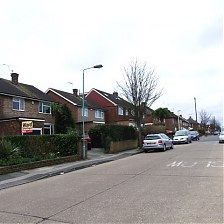

In [19]:
# quick test
predict(3870074, human=True)
# predict(3870074, human=False)

In [20]:
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [21]:
%%time

predictions = test_ids.assign(
    tags=lambda df_: df_.gridimage_id.parallel_apply(predict)
)

CPU times: user 1min 8s, sys: 20.1 s, total: 1min 28s
Wall time: 1h 48min 47s


In [22]:
predictions_df = pd.DataFrame(
    # Convert each tensor to a numpy array and squeeze out the first dimension
    np.vstack([tensor.numpy().squeeze() for tensor in predictions.tags])
)

predictions_df.index = predictions.gridimage_id
predictions_df.columns = tags

In [24]:
predictions_df.to_csv('submissions/submission3.csv.zip')

In [25]:
len(predictions_df)

135489

## Location + title

## VGGNet

In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models, transforms

In [ ]:
# ── TRAIN/VALIDATE UTILS ─────────────────────────────────────────────────
def train_one_epoch(model, loader, opt, crit):
    model.train()
    total = 0.0
    for imgs, tg in tqdm(loader, desc="Train"):
        imgs, tg = imgs.to(DEVICE), tg.to(DEVICE)
        opt.zero_grad()
        out = model(imgs)
        loss= crit(out, tg)
        loss.backward()
        opt.step()
        total += loss.item()*imgs.size(0)
    return total/len(loader.dataset)

def eval_one_epoch(model, loader, crit):
    model.eval()
    total = 0.0
    with torch.no_grad():
        for imgs, tg in tqdm(loader, desc="Validate"):
            imgs, tg = imgs.to(DEVICE), tg.to(DEVICE)
            out = model(imgs)
            total += crit(out, tg).item()*imgs.size(0)
    return total/len(loader.dataset)

In [ ]:
DEVICE     = torch.device("cuda" if torch.cuda.is_available() else "cpu")
OUT_MODEL  = "efficientnet_b0_multi.pth"

ransform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std= [0.229, 0.224, 0.225]
        ),
    ])

full_ds =
tr_ld =
va_ld =


# build EfficientNet-B0
eff = models.efficientnet_b0(pretrained=True)
# freeze features
for p in eff.features.parameters():
    p.requires_grad = False
# replace classifier
num_labels = len(full_ds.tag_cols)
eff.classifier[-1] = nn.Linear(eff.classifier[-1].in_features, num_labels)
eff = eff.to(DEVICE)

crit = nn.BCEWithLogitsLoss()
opt  = optim.Adam(eff.classifier.parameters(), lr=args.lr)

best_val = float("inf")
for ep in range(1, args.epochs+1):
    tr_loss = train_one_epoch(eff, tr_ld, opt, crit)
    va_loss = eval_one_epoch(eff, va_ld, crit)
    print(f"Epoch {ep}/{args.epochs}  train={tr_loss:.4f}  val={va_loss:.4f}")
    if va_loss < best_val:
        best_val = va_loss
        torch.save({
            "model_state": eff.state_dict(),
            "tag_cols":    full_ds.tag_cols
        }, args.checkpoint)
        print(f"  ✨ Saved checkpoint to {args.checkpoint}")

print("Done. best val loss:", best_val)


## EfficientNet

In [ ]:
from torchvision import models, transforms

eff = models.efficientnet_b0(pretrained=True)
